# FW-AL code

This notebook provide a version of the code of the Frank-Wolfe splitting with away steps via augmented lagragian method for simultaneously low rank and sparse matrix recovery.

See Sec. 5 in http://proceedings.mlr.press/v84/gidel18a/gidel18a.pdf

In this notebook. rho correspond to the augemented coefficient $\lambda$ in the paper and alpha cerrespond to $\eta$ in the paper.

In [1]:
%pylab inline
plt.rcParams['figure.figsize'] = (1 * 10.0, 1 * 9.0)
plt.rcParams['font.size'] = 30

Populating the interactive namespace from numpy and matplotlib


In [7]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy import linalg, optimize
from datetime import datetime
#import copt as cp

#from joblib import Memory
#memory = Memory(cachedir='.', verbose=0)

#### Generate synthetic data ####
np.random.seed(1)

sigma_2 = 0.6
N = 200
d = 100
blocks = np.array([2 * d /10,1 * d /10,1 * d /10,3 * d /10,3 * d / 10]).astype(np.int)
epsilon = 10**(-15)

mu = np.zeros(d)
Sigma = np.zeros((d,d))
blck = 0
for k in range(len(blocks)):
    v = 2 * np.random.rand(int(blocks[k]),1)
    v = v * (abs(v) > 0.9)
    Sigma[blck:blck+blocks[k],blck:blck+blocks[k]] = np.dot(v, v.T)
    blck = blck + blocks[k]
X = np.random.multivariate_normal(mu,Sigma + epsilon * np.eye(d) ,N) + sigma_2 * np.random.randn(N,d);
Sigma_hat = np.cov(X.T);    
# Sigma_hat = Sigma + sigma_2 * np.random.randn(d,d);

threshold = 1e-5
Sigma[np.abs(Sigma) < threshold] = 0
Sigma[np.abs(Sigma) >= threshold] = 1

In [8]:
import scipy.sparse as sparse
def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimization problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if (v.sum() <= s) and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = np.zeros(len(v))
    w = (v - theta).clip(min=0)
    return w

def acc_trace_norm_ball(A,rank_sol = 10,cte = 1.,beta = 1.):
    n = A.shape[0]
    (u,s,v) = sparse.linalg.svds(A, k = rank_sol,which = 'LM')
    to_proj = cte * s 
    a = euclidean_proj_simplex(to_proj,s=beta)
    V = np.diag(a)
    V = np.dot(u,np.dot(V,v))
    #for k in range(rank_sol):
    #    V = V + a[k] * np.dot(np.array([u[:,k]]).T, np.array([v[k,:]]))
    #from IPython.core.debugger import Tracer; Tracer()()
    return V

def trace_norm_ball(G, beta=1.):
    (eig_val,eig_vect) = sparse.linalg.eigsh(G, k =1,which = 'LM')
    #from IPython.core.debugger import Tracer; Tracer()()
    return -np.sign(eig_val[0]) * beta * np.dot(np.array([eig_vect[:,0]]).T, np.array([eig_vect[:,0]]))

def oracle_simplex(G,lambd):
    V = np.zeros(G.shape)
    i = np.unravel_index(np.argmin(G),G.shape)
    #from IPython.core.debugger import Tracer; Tracer()()
    V[i] = lambd
    return V

def M_s(X):
    n = X.shape[0] # n is even
    assert mod(n,2) == 0
    return X[:n//2,:] - X[n//2:,:]
def M_s_T(X):
    n = X.shape[0]
    X_2 = np.zeros((2 * n,n))
    X_2[:n,:] = X
    X_2[n:,:] = -X
    return X_2
    

In [10]:
import numpy as np
from scipy import optimize
import scipy.linalg
def afwal(S, lambd, beta, rank_sol = 20, epsilon=1e-15, max_iter=1000, rho=1., alpha_0=1., verbose=False, X_star = None,away_step = False):
    X_1 = np.zeros((2*S.shape[0],S.shape[1]))
    X_1[0,0] = lambd /2
    X_1[S.shape,0] = lambd/2
    # Construct matrix to go to simplex to l1 ball
    X_2 = M_s(X_1)
    Y = np.zeros(S.shape)
    n_iter = 1
    if not(X_star is None):
        f_obj = ((.5*(M_s(X_1)+X_2)- X_star)**2).sum()
        l_f = [f_obj]
    else:
        l_f = []
    while (n_iter <= max_iter):
        # This algorithm sequentially performs a AFW step and a linear trace ball step.
        # ======= Compute the AFW direction ==========
        G_1 = M_s_T(M_s(X_1) - S) + M_s_T(Y) + rho * M_s_T(M_s(X_1) - X_2)
        S_1 = oracle_simplex(G_1,lambd)
        G_1_away = np.copy(-G_1)
        G_1_away[X_1 == 0] = float('inf') 
        V_1 = oracle_simplex(G_1_away,lambd)             #Compute the away corner
        gamma_1_max = min(np.min(np.abs(X_1[X_1 > 10**-10])) / np.max(V_1),1) #Compute the max step size.
        D_1 = S_1 - V_1
        gap_1 = -np.sum(np.sum(G_1 * D_1))
        gap_1_FW = -np.sum(np.sum(G_1 * (S_1 - X_1)))
        gap_1_A  = -np.sum(np.sum(G_1 * (X_1 - V_1)))
        if away_step:
            if gap_1_A > gap_1_FW:
                D_1 = X_1 - V_1
                gamma_max = gamma_1_max / (1- gamma_1_max)
            else:
                D_1 = S_1 - X_1
                gamma_max = 1
        else: 
            D_1 = D_1 = S_1 - V_1
            gamma_max = gamma_1_max
        if not (gap_1_FW >= 0):
            print('first FW gap negative! \n')
            from IPython.core.debugger import Tracer; Tracer()() #this one triggers the debugger       
            break 
        if not (gap_1_A >= 0):
            print('away gap negative! \n')
            from IPython.core.debugger import Tracer; Tracer()() #this one triggers the debugger       
            break   
        


        # ========== Trace Norm direction =============
        L   = 1 + rho
        eta = 1./(2*L)
        G_2 =  (X_2 - S) - Y + rho * (X_2 - M_s(X_1))
        A_2 = L * eta * X_2 - G_2
        V_2 = acc_trace_norm_ball(A_2,rank_sol= rank_sol,cte = 1./(L *eta),beta = beta)
        S_2 = trace_norm_ball(G_2,beta)
        D_2 = S_2 - X_2
        gap_2_FW = -np.sum(np.sum(G_2 * (S_2 - X_2)))
        gap_2 = -np.sum(np.sum(G_2 * D_2))
        if gap_2 < -10**-8:
            print('second gap negative! \n')
            #from IPython.core.debugger import Tracer; Tracer()() #this one triggers the debugger       
            #break  
       
        gamma = (gap_1 + gap_2) / ((M_s(D_1)**2).sum() + (D_2 * D_2).sum() + rho * ((M_s(D_1) - D_2) **2).sum())
        gamma = min(gamma,gamma_max) 
        
        
        # === Bad step sizes just to try ======
        gamma_1 = gap_1 / ((1+rho)*((M_s(D_1)**2).sum()))
        gamma_1 = min(gamma_1,gamma_max)
        gamma_2 = gap_2 / ((1+rho)*((D_2)**2).sum())
        gamma_2 = min(gamma_2,1)
                        
        X_2 = X_2 + gamma_2 * D_2
        X_1 = X_1 + gamma_1 * D_1
        # ============== Update the dual variable ===========
        if gamma < gamma_max or gamma == 1 :
            alpha = alpha_0
            Y = Y + alpha * (M_s(X_1) - X_2)
        n_iter += 1    
         # =========== If verbose, print information ======
        if np.mod(n_iter,max_iter/10) ==0:
            if verbose:
                #from IPython.core.debugger import Tracer; Tracer()() #this one triggers the debugger 
                print('Current gap: {}, Feasibility: {}, norm_Y : {}, step_size: {} after {} iterations \n'.format(gap_1_FW + gap_2_FW,((M_s(X_1)-X_2)**2).sum(), (Y*Y).sum(),gamma,  n_iter))
        if not(X_star is None):
            f_obj = ((.5*(M_s(X_1)+X_2)- X_star)**2).sum()
            l_f.append(f_obj)
    
    return X_1, X_2,gap_1_FW + gap_2_FW,((M_s(X_1)-X_2)**2).sum(),l_f
    print('Optimization done, Current gap: {} after {} iterations \n'.format(gap_FW + gap_2,  n_iter))
    

In [11]:
# regularization parameters computed by cross validation
lambd = np.abs(Sigma).sum()
beta = np.trace(Sigma)
print(lambd)
print(beta)

622.0
50.0


In [12]:
X_1,X_2,gap,feas,l_f = afwal(Sigma_hat, lambd, beta, max_iter=10000, rho=2, alpha_0= .001, verbose=True)
X_star = .5*(M_s(X_1) + X_2)
X_1,X_2,gap,feas,l_f = afwal(Sigma_hat, lambd, beta, max_iter=1000, rho=2, alpha_0= .001, verbose=True, X_star = X_star)


Current gap: 349.8899102611198, Feasibility: 22.996681546599987, norm_Y : 0.022400856892086558, step_size: 0.0001984107686595456 after 1000 iterations 

Current gap: 8.796771157103322, Feasibility: 11.563771817105497, norm_Y : 9.19357145606471, step_size: 4.619659448383679e-06 after 2000 iterations 

Current gap: 2.839418867919818, Feasibility: 10.780533873760112, norm_Y : 10.909578549079173, step_size: 1.7837161261742368e-07 after 3000 iterations 

Current gap: 3.8999485969977172, Feasibility: 10.554134453538953, norm_Y : 11.944596222889086, step_size: 2.6868135160101963e-06 after 4000 iterations 

Current gap: 7.838184575439698, Feasibility: 7.060371216864363, norm_Y : 32.984741628511806, step_size: 5.636320814251137e-06 after 5000 iterations 

Current gap: 1.702636823713874, Feasibility: 6.028660321588316, norm_Y : 38.68342220099329, step_size: 8.492965065672745e-07 after 6000 iterations 

Current gap: 1.2106700542752904, Feasibility: 5.872245872155975, norm_Y : 39.37866871218375, s

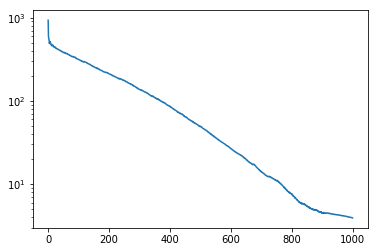

In [13]:
plt.semilogy(l_f)
plt.show()

In [15]:
l_rho = [.1,.2,.3,.4]
l_alpha = [.001,.0001,.0005]
results = {}
for rho in l_rho:
    for alpha in l_alpha:
        X_1,X_2,gap,feas,l_f = afwal(Sigma_hat, lambd, beta, max_iter=10000, rho=rho, alpha_0= alpha, verbose=True)
        results[rho,alpha] = (gap,feas)
    

Current gap: 182.48236011241022, Feasibility: 138.76111058206274, norm_Y : 3.4492156032577705, step_size: 6.2031196887259e-05 after 1000 iterations 

Current gap: 44.26842930513547, Feasibility: 123.1131285562557, norm_Y : 3.4492156032577705, step_size: 6.2031196887259e-05 after 2000 iterations 

Current gap: 17.77617163944518, Feasibility: 33.50939852164698, norm_Y : 47.507628035685016, step_size: 3.223992085307249e-05 after 3000 iterations 

Current gap: 2.3381849012912, Feasibility: 18.937713467243732, norm_Y : 63.79736634791104, step_size: 4.105080638467109e-06 after 4000 iterations 

Current gap: 0.6681151051640768, Feasibility: 17.819884990332344, norm_Y : 64.66520871447074, step_size: 6.163375479110417e-07 after 5000 iterations 

Current gap: 0.5556352875031223, Feasibility: 17.531542106591175, norm_Y : 64.8614980512333, step_size: 4.7352234354468575e-07 after 6000 iterations 

Current gap: 0.40384211186281505, Feasibility: 17.418903674374114, norm_Y : 64.92654942813006, step_si

## Note on the hyperparameters
- The optimization problem is quite sensitive to the the tuning of rho anf alpha
- they have to be properly set
- The bigger rho is the more stable the algorithm is (in the sens gap and feasability constantly deacrease)
- BUT the bigger rho is the slower the optimization is
- The same way if alpha_0 is too big the algorithm diverge
- If alpha_0 is too small the optimization is too slow. 


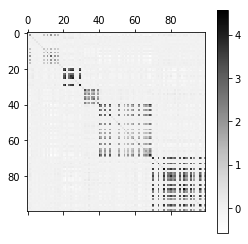

In [16]:
# plot sigma_hat

def obj_fun(X):
    Z = X - Sigma_hat
    return 0.5 * (Z * Z).mean()

plt.matshow(Sigma_hat, interpolation='nearest', cmap=plt.cm.Greys)
plt.colorbar()
plt.show()

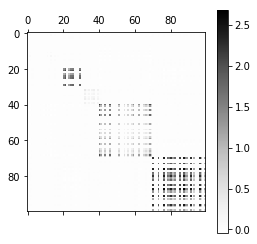

In [17]:
plt.matshow((X_star), interpolation='nearest', cmap=plt.cm.Greys)
plt.colorbar()
plt.show()

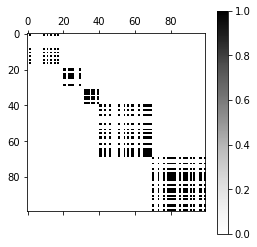

In [18]:
plt.matshow(Sigma, interpolation='nearest', cmap=plt.cm.Greys)
plt.colorbar()
plt.show()